# Demand forecasting with the Temporal Fusion Transformer

https://www.youtube.com/watch?v=M7O4VqRf8s4

Our example is a demand forecast from the [Stallion kaggle competition](https://www.kaggle.com/utathya/future-volume-prediction).

In [1]:
import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

/home/adrian/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
2022-09-11 15:08:03.609190: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network L

## Load data

First, we need to transform our time series into a pandas dataframe where each row can be identified with a time step and a time series. Fortunately, most datasets are already in this format. For this tutorial, we will use the [Stallion dataset from Kaggle](https://www.kaggle.com/utathya/future-volume-prediction) describing sales of various beverages. Our task is to make a six-month forecast of the sold volume by stock keeping units (SKU), that is products, sold by an agency, that is a store. There are about 21 000 monthly historic sales records. In addition to historic sales we have information about the sales price, the location of the agency, special days such as holidays, and volume sold in the entire industry.

The dataset is already in the correct format but misses some important features. Most importantly, we need to add a time index that is incremented by one for each time step. Further, it is beneficial to add date features, which in this case means extracting the month from the date record.

In [2]:
from pytorch_forecasting.data.examples import get_stallion_data

data = get_stallion_data()

# add time index
data["time_idx"] = data["date"].dt.year * 12 + data["date"].dt.month
data["time_idx"] -= data["time_idx"].min()

# add additional features
data["month"] = data.date.dt.month.astype(str).astype("category")  # categories have be strings
data["log_volume"] = np.log(data.volume + 1e-8)
data["avg_volume_by_sku"] = data.groupby(["time_idx", "sku"], observed=True).volume.transform("mean")
data["avg_volume_by_agency"] = data.groupby(["time_idx", "agency"], observed=True).volume.transform("mean")

# we want to encode special days as one variable and thus need to first reverse one-hot encoding
special_days = [
    "easter_day",
    "good_friday",
    "new_year",
    "christmas",
    "labor_day",
    "independence_day",
    "revolution_day_memorial",
    "regional_games",
    "fifa_u_17_world_cup",
    "football_gold_cup",
    "beer_capital",
    "music_fest",
]
data[special_days] = data[special_days].apply(lambda x: x.map({0: "-", 1: x.name})).astype("category")
data.sample(10, random_state=521)

,agency,sku,volume,date,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,...,football_gold_cup,beer_capital,music_fest,discount_in_percent,timeseries,time_idx,month,log_volume,avg_volume_by_sku,avg_volume_by_agency
291,Agency_25,SKU_03,0.5076,2013-01-01,492612703,718394219,25.845238,1264.162234,1152.473405,111.688829,...,-,-,-,8.835008,228,0,1,-0.678062,1225.306376,99.650400
871,Agency_29,SKU_02,8.7480,2015-01-01,498567142,762225057,27.584615,1316.098485,1296.804924,19.293561,...,-,-,-,1.465966,177,24,1,2.168825,1634.434615,11.397086
19532,Agency_47,SKU_01,4.9680,2013-09-01,454252482,789624076,30.665957,1269.250000,1266.490490,2.759510,...,-,-,-,0.217413,322,8,9,1.603017,2625.472644,48.295650
2089,Agency_53,SKU_07,21.6825,2013-10-01,480693900,791658684,29.197727,1193.842373,1128.124395,65.717978,...,-,beer_capital,-,5.504745,240,9,10,3.076505,38.529107,2511.035175
9755,Agency_17,SKU_02,960.5520,2015-03-01,515468092,871204688,23.608120,1338.334248,1232.128069,106.206179,...,-,-,music_fest,7.935699,259,26,3,6.867508,2143.677462,396.022140
7561,Agency_05,SKU_03,1184.6535,2014-02-01,425528909,734443953,28.668254,1369.556376,1161.135214,208.421162,...,-,-,-,15.218151,21,13,2,7.077206,1566.643589,1881.866367
19204,Agency_11,SKU_05,5.5593,2017-08-01,623319783,1049868815,31.915385,1922.486644,1651.307674,271.178970,...,-,-,-,14.105636,17,55,8,1.715472,1385.225478,109.699200
8781,Agency_48,SKU_04,4275.1605,2013-03-01,509281531,892192092,26.767857,1761.258209,1546.059670,215.198539,...,-,-,music_fest,12.218455,151,2,3,8.360577,1757.950603,1925.272108
2540,Agency_07,SKU_21,0.0000,2015-10-01,544203593,761469815,28.987755,0.000000,0.000000,0.000000,...,-,-,-,0.000000,300,33,10,-18.420681,0.000000,2418.719550
12084,Agency_21,SKU_03,46.3608,2017-04-01,589969396,940912941,32.478910,1675.922116,1413.571789,262.350327,...,-,-,-,15.654088,181,51,4,3.836454,2034.293024,109.381800


In [3]:
data.describe()

,volume,industry_volume,soda_volume,avg_max_temp,price_regular,price_actual,discount,avg_population_2017,avg_yearly_household_income_2017,discount_in_percent,timeseries,time_idx,log_volume,avg_volume_by_sku,avg_volume_by_agency
count,21000.000000,2.100000e+04,2.100000e+04,21000.000000,21000.000000,21000.000000,21000.000000,2.100000e+04,21000.000000,21000.000000,21000.00000,21000.000000,21000.000000,21000.000000,21000.000000
mean,1492.403982,5.439214e+08,8.512000e+08,28.612404,1451.536344,1267.347450,184.374146,1.045065e+06,151073.494286,10.574884,174.50000,29.500000,2.464118,1492.403982,1492.403982
std,2711.496882,6.288022e+07,7.824340e+07,3.972833,683.362417,587.757323,257.469968,9.291926e+05,50409.593114,9.590813,101.03829,17.318515,8.178218,1051.790829,1328.239698
min,0.000000,4.130518e+08,6.964015e+08,16.731034,0.000000,-3121.690141,0.000000,1.227100e+04,90240.000000,0.000000,0.00000,0.000000,-18.420681,0.000000,0.000000
25%,8.272388,5.090553e+08,7.890880e+08,25.374816,1311.547158,1178.365653,54.935108,6.018900e+04,110057.000000,3.749628,87.00000,14.750000,2.112923,932.285496,113.420250
50%,158.436000,5.512000e+08,8.649196e+08,28.479272,1495.174592,1324.695705,138.307225,1.232242e+06,131411.000000,8.948990,174.50000,29.500000,5.065351,1402.305264,1730.529771
75%,1774.793475,5.893715e+08,9.005551e+08,31.568405,1725.652080,1517.311427,272.298630,1.729177e+06,206553.000000,15.647058,262.00000,44.250000,7.481439,2195.362302,2595.316500
max,22526.610000,6.700157e+08,1.049869e+09,45.290476,19166.625000,4925.404000,19166.625000,3.137874e+06,247220.000000,226.740147,349.00000,59.000000,10.022453,4332.363750,5884.717375


### Create dataset and dataloaders

In [ ]:
max_prediction_length = 6
max_encoder_length = 24
training_cutoff = data["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="volume",
    group_ids=["agency", "sku"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    static_categoricals=["agency", "sku"],
    static_reals=["avg_population_2017", "avg_yearly_household_income_2017"],
    time_varying_known_categoricals=["special_days", "month"],
    variable_groups={"special_days": special_days},  # group of categorical variables can be treated as one variable
    time_varying_known_reals=["time_idx", "price_regular", "discount_in_percent"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[
        "volume",
        "log_volume",
        "industry_volume",
        "soda_volume",
        "avg_max_temp",
        "avg_volume_by_agency",
        "avg_volume_by_sku",
    ],
    target_normalizer=GroupNormalizer(
        groups=["agency", "sku"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=4)

NameError: name 'data' is not defined

## Create baseline model

In [5]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
actuals = torch.cat([y for x, (y, weight) in iter(val_dataloader)])
baseline_predictions = Baseline().predict(val_dataloader)
(actuals - baseline_predictions).abs().mean().item()

/home/adrian/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/adrian/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


293.0088195800781

## Train the Temporal Fusion Transformer

### Find optimal learning rate

Prior to training, you can identify the optimal learning rate with the [PyTorch Lightning learning rate finder](https://pytorch-lightning.readthedocs.io/en/latest/lr_finder.html).

In [6]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    gpus=1,
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=16,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
/home/adrian/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:445: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/adrian/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (QuantileLoss). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking func

Number of parameters in network: 29.7k

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Restoring states from the checkpoint path at /home/adrian/development/personal/maestria/time-series/notebooks/.lr_find_2c1aa405-4b20-470c-a5f7-163388872322.ckpt


suggested learning rate: 0.01862087136662867

<Figure size 432x288 with 1 Axes>

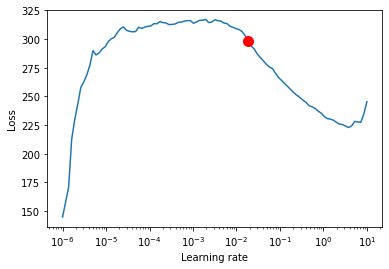

/var/tmp/ipykernel_3962416/450857479.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [7]:
# find optimal learning rate
res = trainer.tuner.lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

### Train model

If you have troubles training the model and get an error ```AttributeError: module 'tensorflow._api.v2.io.gfile' has no attribute 'get_filesystem'```, consider either uninstalling tensorflow or first execute

```
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
```.

In [8]:
from tensorboard.compat import tensorflow_stub

In [9]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=30,
    gpus=1,
    gradient_clip_val=0.1,
    limit_train_batches=30,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=8,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 29.7k

Training takes a couple of minutes on my Macbook but for larger networks and datasets, it can take hours. The training speed is here mostly determined by overhead and choosing a larger `batch_size` or `hidden_size` (i.e. network size) does not slow does training linearly making training on large datasets feasible. During training, we can monitor the tensorboard which can be spun up with `tensorboard --logdir=lightning_logs`. For example, we can monitor examples predictions on the training and validation set.

In [10]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 1.3 K 
3  | prescalers                         | ModuleDict                      | 256   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.4 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 8.0 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 2.7 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm 

Sanity Checking: 0it [00:00, ?it/s]

/home/adrian/.local/lib/python3.10/site-packages/pytorch_lightning/trainer/trainer.py:1894: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


### Hyperparameter tuning

## Evaluate performance

PyTorch Lightning automatically checkpoints training and thus, we can easily retrieve the best model and load it.

In [24]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/home/adrian/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/home/adrian/.local/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [25]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(252.3017)

In [26]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)

<Figure size 432x288 with 2 Axes>

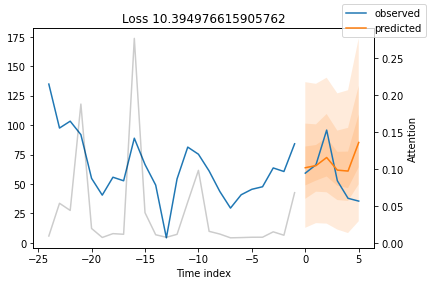

<Figure size 432x288 with 2 Axes>

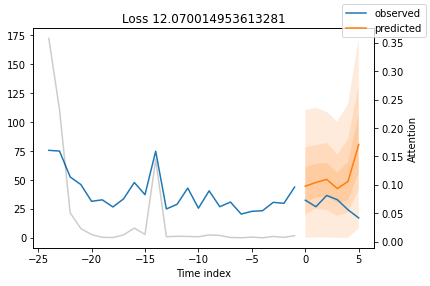

<Figure size 432x288 with 2 Axes>

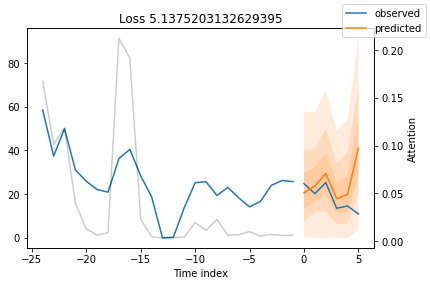

<Figure size 432x288 with 2 Axes>

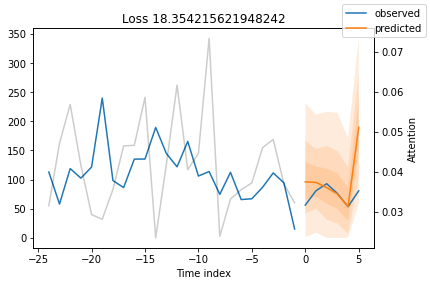

<Figure size 432x288 with 2 Axes>

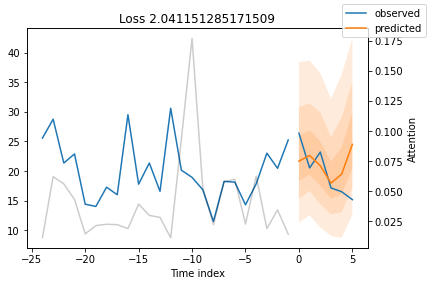

<Figure size 432x288 with 2 Axes>

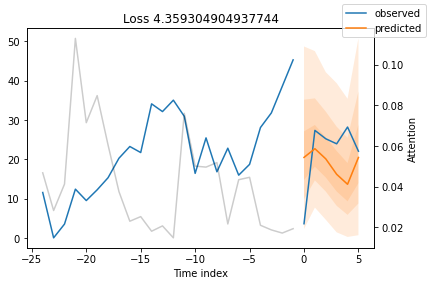

<Figure size 432x288 with 2 Axes>

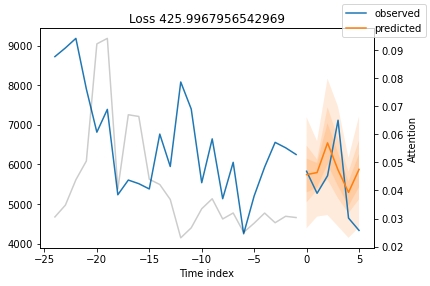

<Figure size 432x288 with 2 Axes>

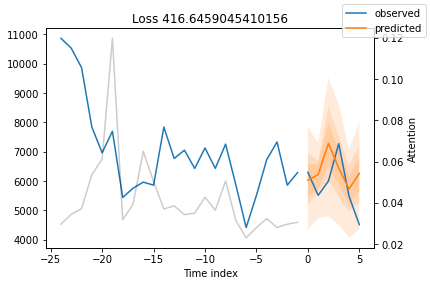

<Figure size 432x288 with 2 Axes>

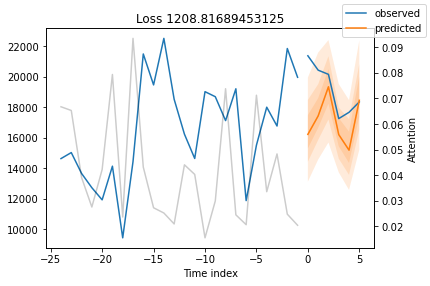

<Figure size 432x288 with 2 Axes>

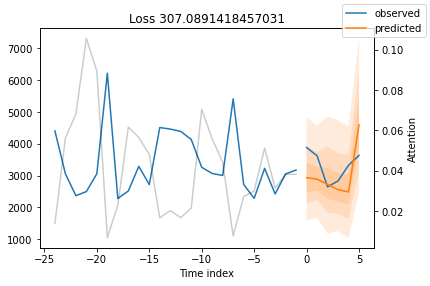

In [27]:
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

### Worst performers

/home/adrian/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (SMAPE). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)
/home/adrian/.local/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class p

<Figure size 432x288 with 2 Axes>

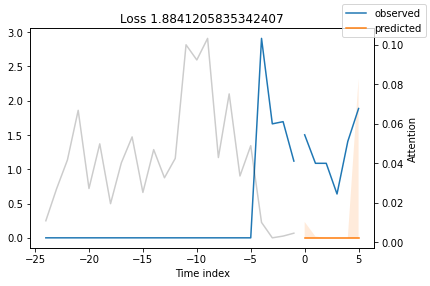

<Figure size 432x288 with 2 Axes>

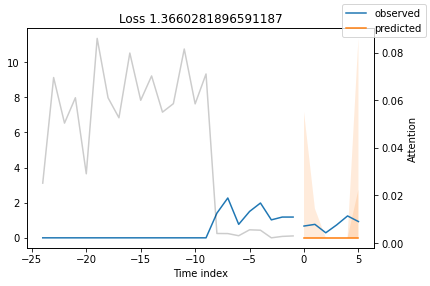

<Figure size 432x288 with 2 Axes>

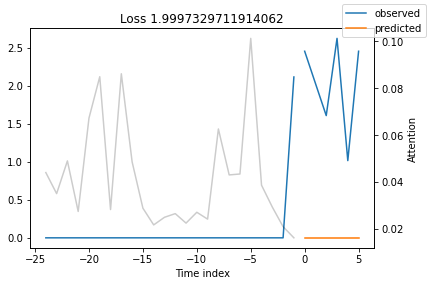

<Figure size 432x288 with 2 Axes>

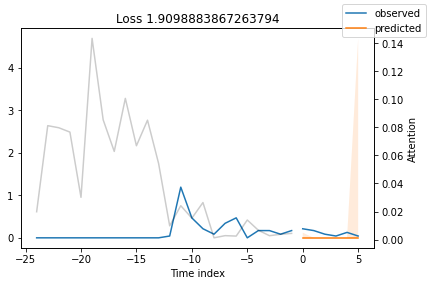

<Figure size 432x288 with 2 Axes>

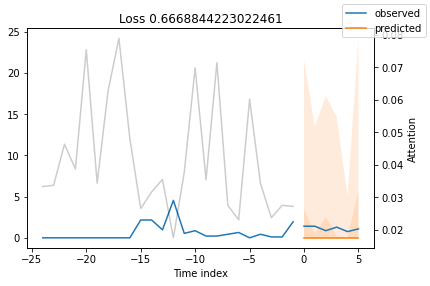

<Figure size 432x288 with 2 Axes>

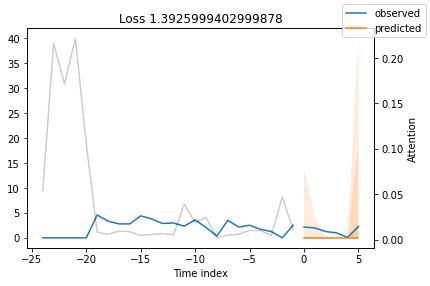

<Figure size 432x288 with 2 Axes>

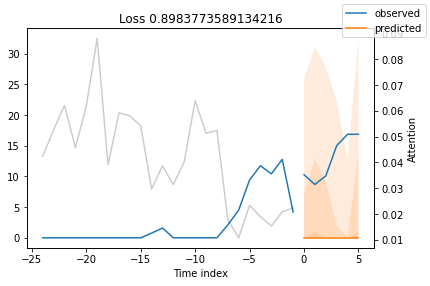

<Figure size 432x288 with 2 Axes>

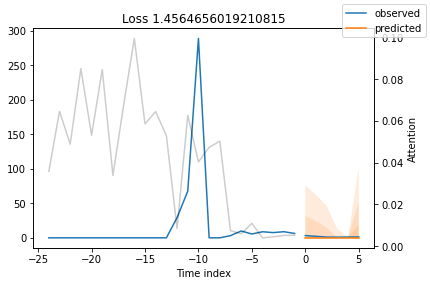

<Figure size 432x288 with 2 Axes>

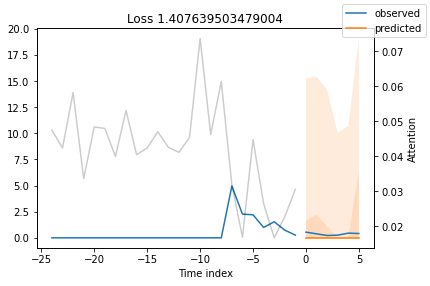

<Figure size 432x288 with 2 Axes>

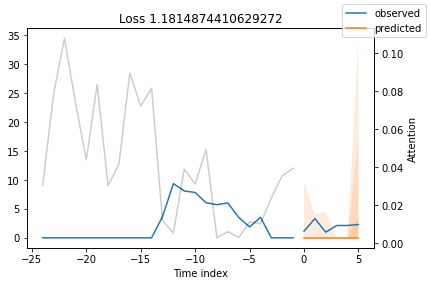

In [28]:
# calcualte metric by which to display
predictions = best_tft.predict(val_dataloader)
mean_losses = SMAPE(reduction="none")(predictions, actuals).mean(1)
indices = mean_losses.argsort(descending=True)  # sort losses
for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(
        x, raw_predictions, idx=indices[idx], add_loss_to_title=SMAPE(quantiles=best_tft.loss.quantiles)
    );

### Actuals vs predictions by variables

/home/adrian/.conda/envs/time-series/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6


<Figure size 720x360 with 2 Axes>

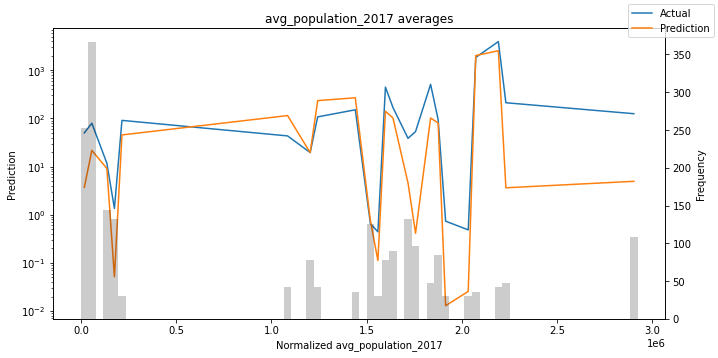

<Figure size 720x360 with 2 Axes>

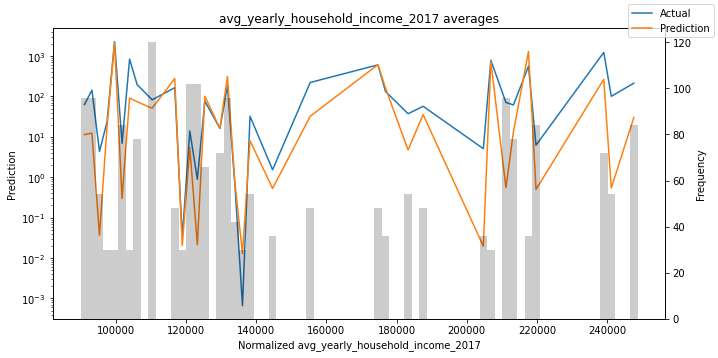

<Figure size 720x360 with 2 Axes>

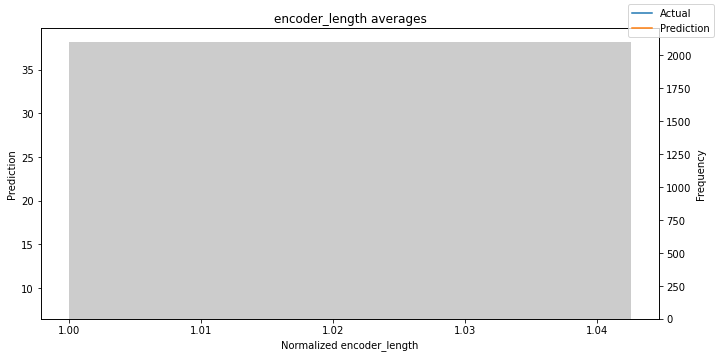

<Figure size 720x360 with 2 Axes>

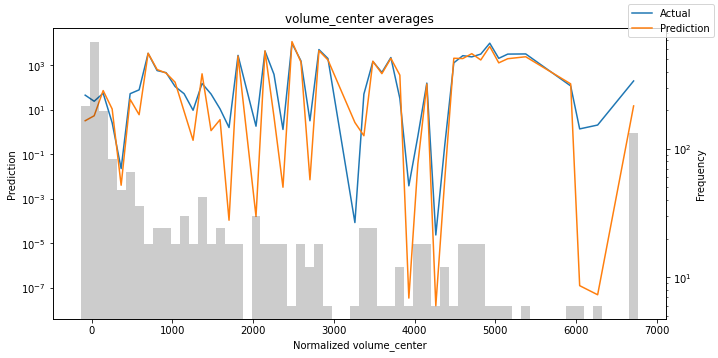

<Figure size 720x360 with 2 Axes>

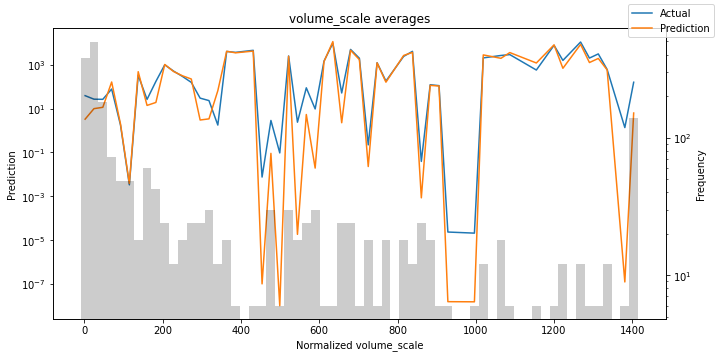

<Figure size 720x360 with 2 Axes>

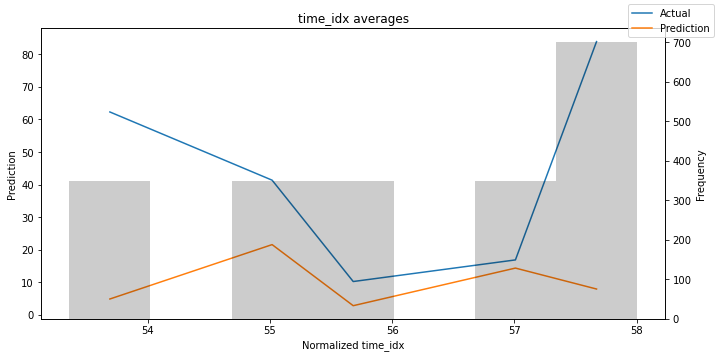

<Figure size 720x360 with 2 Axes>

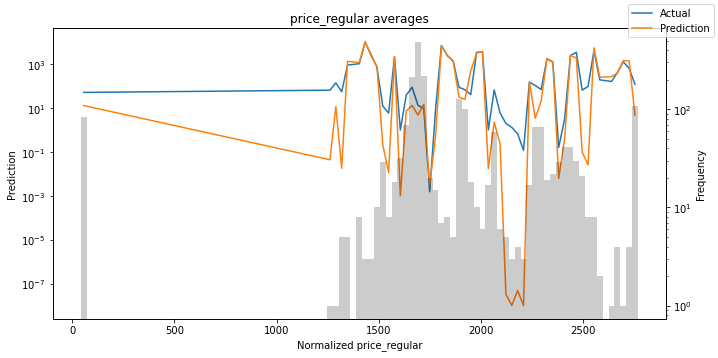

<Figure size 720x360 with 2 Axes>

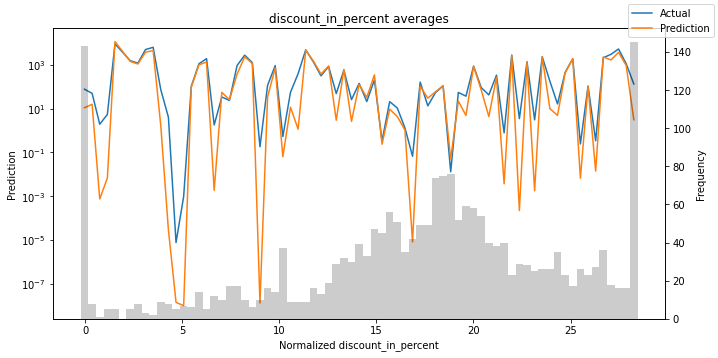

<Figure size 720x360 with 2 Axes>

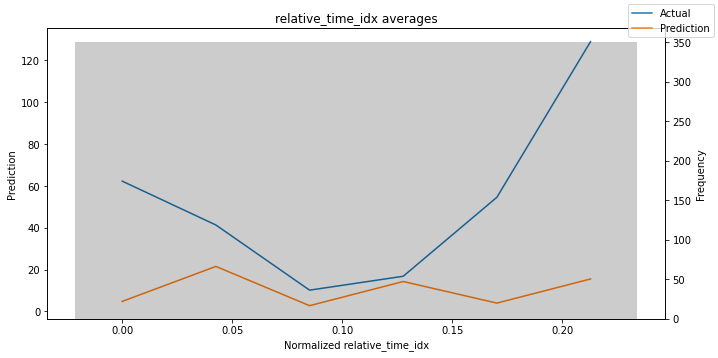

<Figure size 720x360 with 2 Axes>

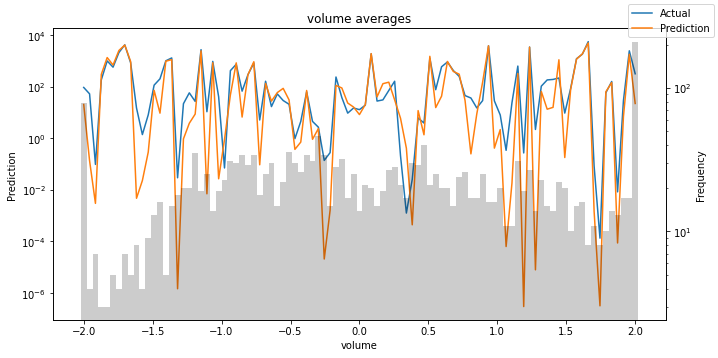

<Figure size 720x360 with 2 Axes>

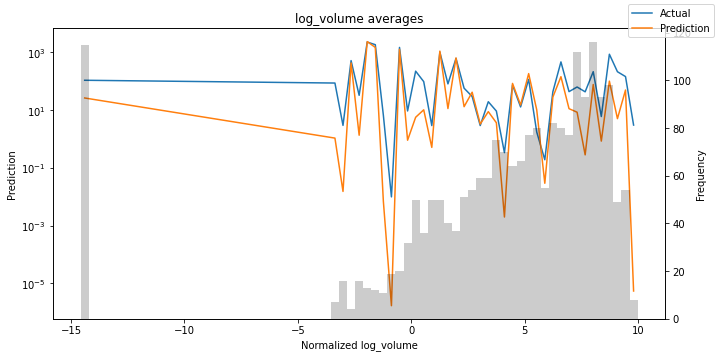

<Figure size 720x360 with 2 Axes>

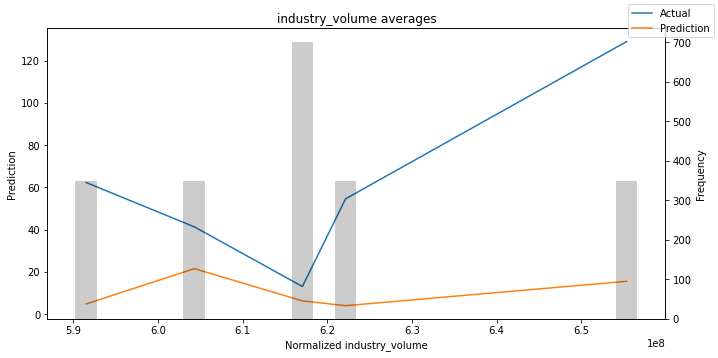

<Figure size 720x360 with 2 Axes>

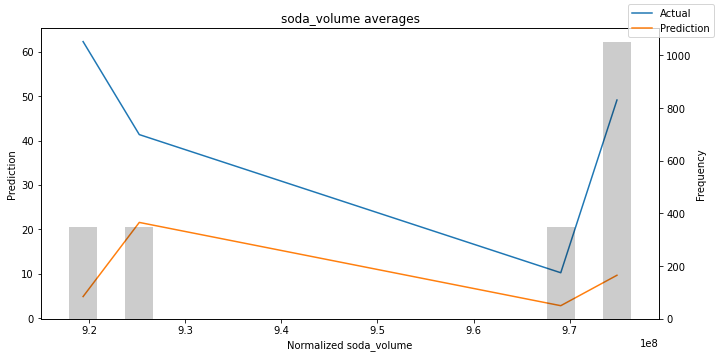

<Figure size 720x360 with 2 Axes>

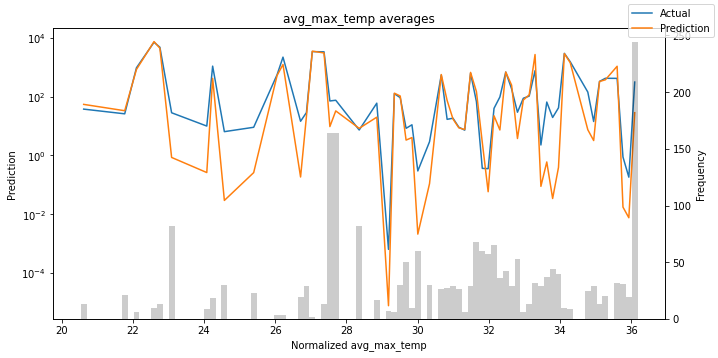

<Figure size 720x360 with 2 Axes>

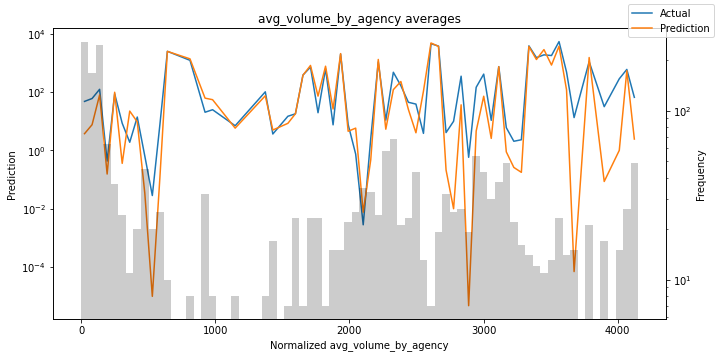

<Figure size 720x360 with 2 Axes>

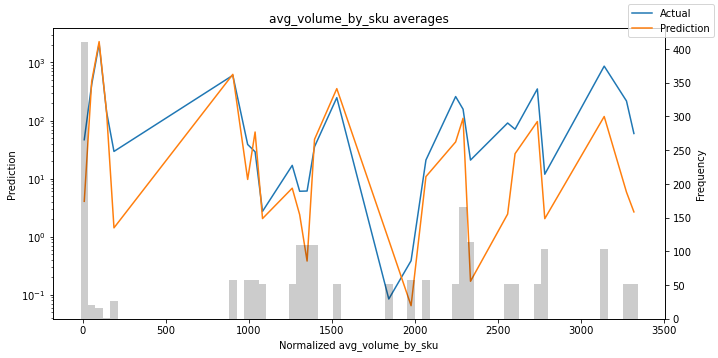

<Figure size 720x360 with 2 Axes>

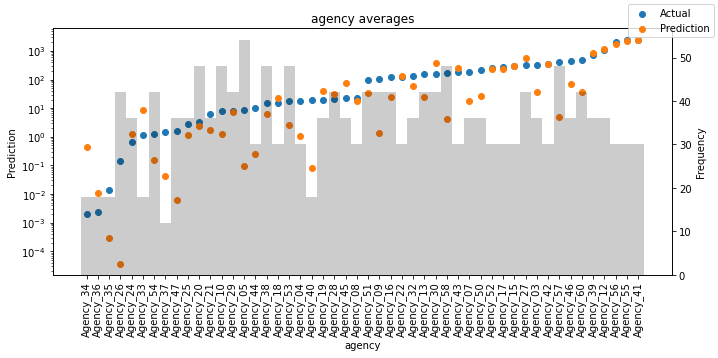

<Figure size 720x360 with 2 Axes>

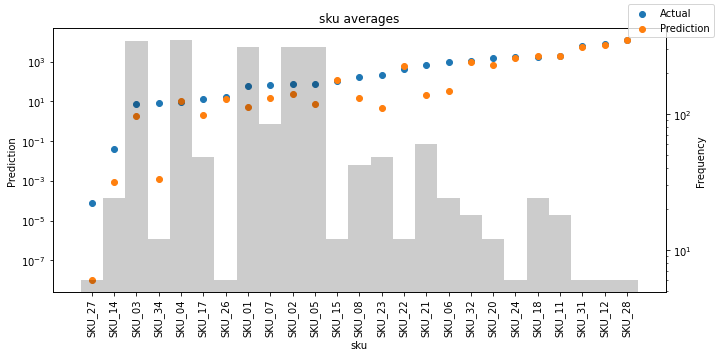

<Figure size 720x360 with 2 Axes>

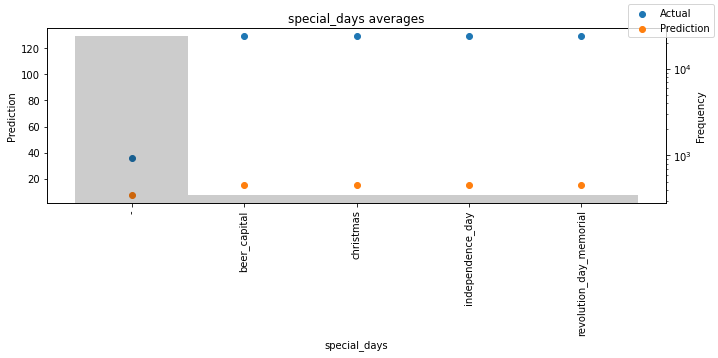

<Figure size 720x360 with 2 Axes>

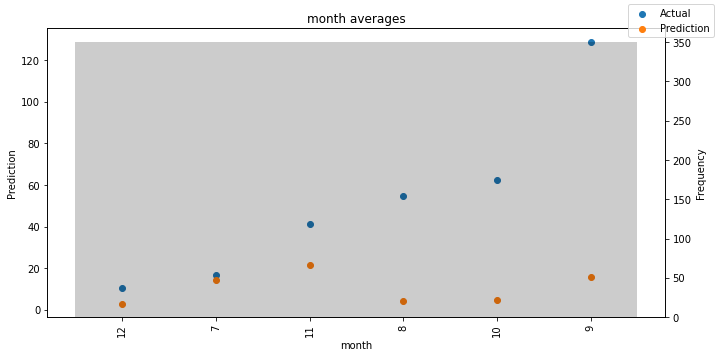

In [29]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

## Predict on selected data

In [30]:
best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="quantiles",
)

tensor([[[ 72.1705, 101.8691, 116.1760, 132.6847, 150.9991, 170.9194, 200.3443],
         [ 46.0805,  73.3897,  91.5822, 110.4470, 129.1432, 148.9234, 181.5182],
         [ 44.0460,  68.8428,  85.0482, 102.5267, 119.7080, 137.5882, 167.1539],
         [ 45.6163,  68.1425,  84.2863, 102.1652, 121.7526, 141.1763, 174.5788],
         [ 49.8201,  75.0798,  86.5815, 102.5413, 119.9802, 136.2118, 167.5110],
         [ 36.7405,  62.1879,  75.4504,  91.4252, 107.6078, 124.6329, 152.0884]]])

Of course, we can also plot this prediction readily:

<Figure size 432x288 with 2 Axes>

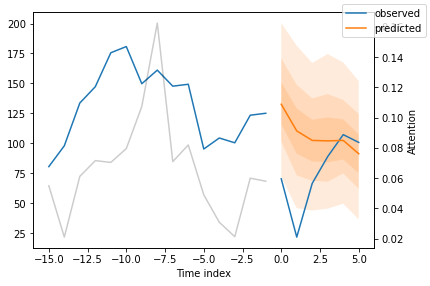

In [31]:
raw_prediction, x = best_tft.predict(
    training.filter(lambda x: (x.agency == "Agency_01") & (x.sku == "SKU_01") & (x.time_idx_first_prediction == 15)),
    mode="raw",
    return_x=True,
)
best_tft.plot_prediction(x, raw_prediction, idx=0);

## Predict on new data

Because we have covariates in the dataset, predicting on new data requires us to define the known covariates upfront.

In [32]:
# select last 24 months from data (max_encoder_length is 24)
encoder_data = data[lambda x: x.time_idx > x.time_idx.max() - max_encoder_length]

# select last known data point and create decoder data from it by repeating it and incrementing the month
# in a real world dataset, we should not just forward fill the covariates but specify them to account
# for changes in special days and prices (which you absolutely should do but we are too lazy here)
last_data = data[lambda x: x.time_idx == x.time_idx.max()]
decoder_data = pd.concat(
    [last_data.assign(date=lambda x: x.date + pd.offsets.MonthBegin(i)) for i in range(1, max_prediction_length + 1)],
    ignore_index=True,
)

# add time index consistent with "data"
decoder_data["time_idx"] = decoder_data["date"].dt.year * 12 + decoder_data["date"].dt.month
decoder_data["time_idx"] += encoder_data["time_idx"].max() + 1 - decoder_data["time_idx"].min()

# adjust additional time feature(s)
decoder_data["month"] = decoder_data.date.dt.month.astype(str).astype("category")  # categories have be strings

# combine encoder and decoder data
new_prediction_data = pd.concat([encoder_data, decoder_data], ignore_index=True)

<Figure size 432x288 with 2 Axes>

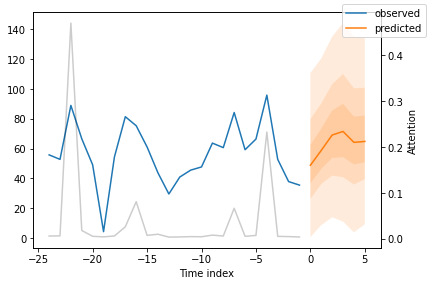

<Figure size 432x288 with 2 Axes>

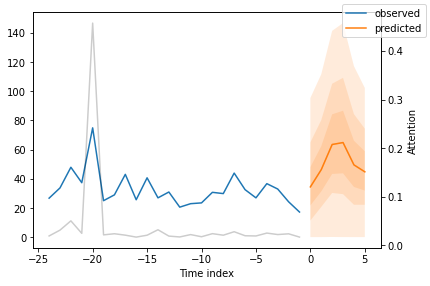

<Figure size 432x288 with 2 Axes>

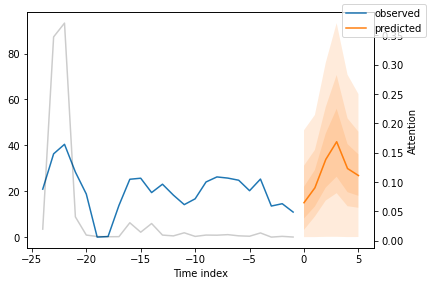

<Figure size 432x288 with 2 Axes>

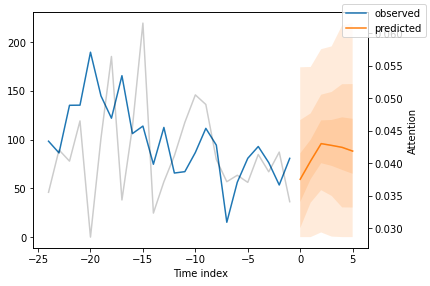

<Figure size 432x288 with 2 Axes>

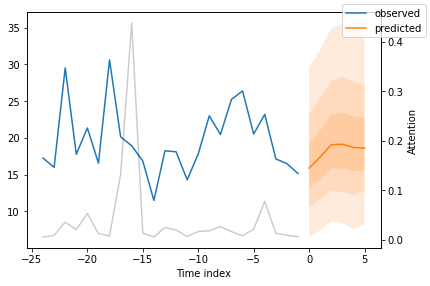

<Figure size 432x288 with 2 Axes>

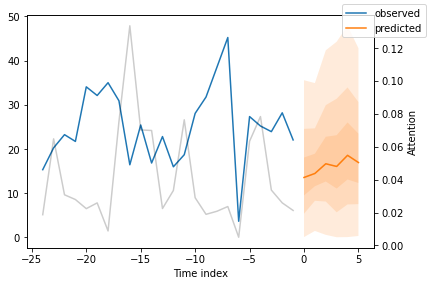

<Figure size 432x288 with 2 Axes>

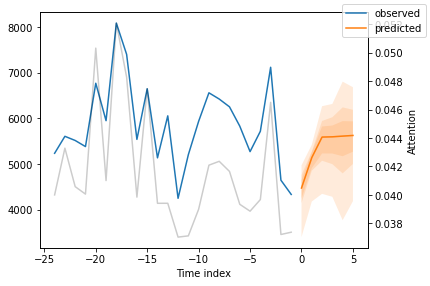

<Figure size 432x288 with 2 Axes>

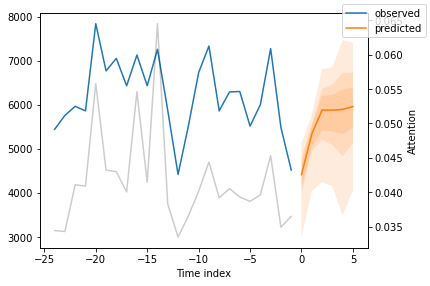

<Figure size 432x288 with 2 Axes>

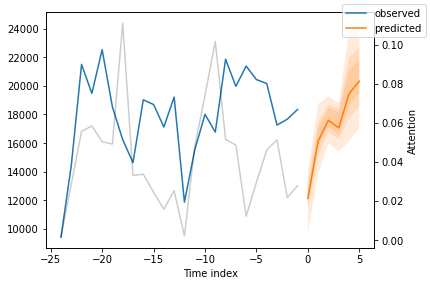

<Figure size 432x288 with 2 Axes>

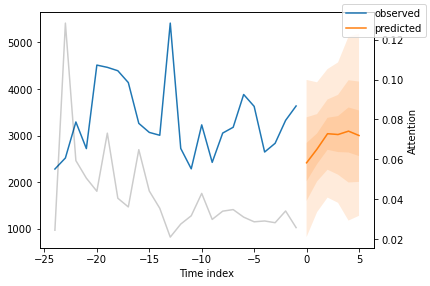

In [33]:
new_raw_predictions, new_x = best_tft.predict(new_prediction_data, mode="raw", return_x=True)

for idx in range(10):  # plot 10 examples
    best_tft.plot_prediction(new_x, new_raw_predictions, idx=idx, show_future_observed=False);

## Interpret model

### Variable importances

{
    'attention': <Figure size 432x288 with 1 Axes>,
    'static_variables': <Figure size 504x270 with 1 Axes>,
    'encoder_variables': <Figure size 504x378 with 1 Axes>,
    'decoder_variables': <Figure size 504x252 with 1 Axes>
}

<Figure size 432x288 with 1 Axes>

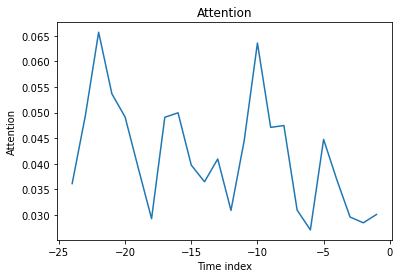

<Figure size 504x270 with 1 Axes>

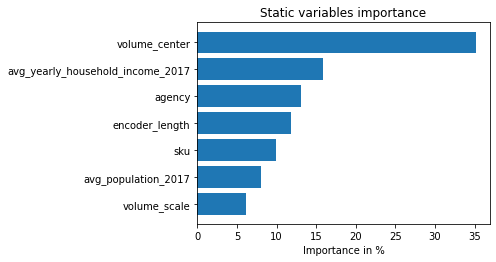

<Figure size 504x378 with 1 Axes>

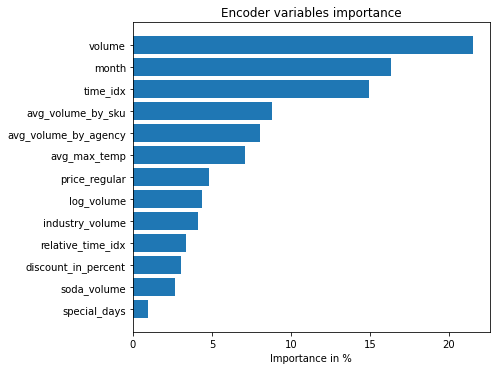

<Figure size 504x252 with 1 Axes>

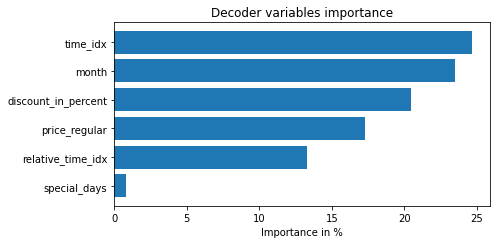

In [34]:
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

Unsurprisingly, the past observed volume features as the top variable in the encoder and price related variables are among the top predictors in the decoder.

The general attention patterns seems to be that more recent observations are more important and older ones. This confirms intuition. The average attention is often not very useful - looking at the attention by example is more insightful because patterns are not averaged out.

### Partial dependency

In [35]:
dependency = best_tft.predict_dependency(
    val_dataloader.dataset, "discount_in_percent", np.linspace(0, 30, 30), show_progress_bar=True, mode="dataframe"
)

Predict:   0%|          | 0/30 [00:00<?, ? batches/s]

/home/adrian/.conda/envs/time-series/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/adrian/.conda/envs/time-series/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/adrian/.conda/envs/time-series/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/adrian/.conda/envs/time-series/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/adrian/.conda/envs/time-series/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  

<Figure size 432x288 with 1 Axes>

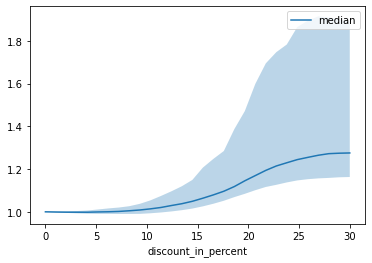

In [36]:
# plotting median and 25% and 75% percentile
agg_dependency = dependency.groupby("discount_in_percent").normalized_prediction.agg(
    median="median", q25=lambda x: x.quantile(0.25), q75=lambda x: x.quantile(0.75)
)
ax = agg_dependency.plot(y="median")
ax.fill_between(agg_dependency.index, agg_dependency.q25, agg_dependency.q75, alpha=0.3);